In [19]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

%matplotlib inline

In [20]:
train = pd.read_csv("train.csv")
test = pd.read_csv('test.csv')

In [21]:
print(train.shape)

(891, 12)


In [22]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## let's check for the missing values 

In [23]:
NAs = pd.concat([train.isnull().sum()], axis=1, keys=['Train'])
NAs[NAs.sum(axis=1) > 0]

,Train
Age,177
Cabin,687
Embarked,2


In [24]:
train.pop('Cabin')
train.pop('Name')
train.pop('Ticket')


0             A/5 21171
1              PC 17599
2      STON/O2. 3101282
3                113803
4                373450
             ...       
886              211536
887              112053
888          W./C. 6607
889              111369
890              370376
Name: Ticket, Length: 891, dtype: object

In [25]:
train.shape

(891, 9)

## Fill missing values

In [26]:
# filling the missing values with mean 
train['Age'] = train['Age'].fillna(train['Age'].mean())


In [27]:
# Filling missing Embarked values with most common value
train['Embarked'] = train['Embarked'].fillna(train['Embarked'].mode()[0])

In [28]:
# ‘Pclass’ is a categorical feature so we convert its values to strings

train['Pclass'] = train['Pclass'].apply(str)

## let's perform one hot encoding

In [29]:
# getting dummies for all other categorical vars
for col in train.dtypes[train.dtypes=='object'].index:
    for_dummy = train.pop(col)
    train = pd.concat([train, pd.get_dummies(for_dummy, prefix=col)], axis=1)

In [30]:
train.head()

,PassengerId,Survived,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,0,22.0,1,0,7.2500,0,0,1,0,1,0,0,1
1,2,1,38.0,1,0,71.2833,1,0,0,1,0,1,0,0
2,3,1,26.0,0,0,7.9250,0,0,1,1,0,0,0,1
3,4,1,35.0,1,0,53.1000,1,0,0,1,0,0,0,1
4,5,0,35.0,0,0,8.0500,0,0,1,0,1,0,0,1


In [31]:
labels = train.pop('Survived')

In [32]:
# lets split the data into 75% and 25% 
from sklearn.model_selection import train_test_split

In [33]:
X_train, X_test, y_train, y_test = train_test_split(train, labels, test_size = 0.25)

## Apply KNN algorithm 

In [34]:
from sklearn.neighbors import KNeighborsClassifier

In [35]:
model = KNeighborsClassifier()

model.fit(X_train, y_train)
print(model)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')


In [36]:
# let's do the predictions
y_pred = model.predict(X_test)

### ROC AND AUC

In [37]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [38]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)

In [39]:
print('False Positive Rate', false_positive_rate)
print('True Positive Rate', true_positive_rate)
print('thresholds', thresholds)

False Positive Rate [0.        0.2027972 1.       ]
True Positive Rate [0.     0.3625 1.    ]
thresholds [2 1 0]


In [40]:
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.5798513986013986

## let's do for n-neighbors 

In [42]:
neighbors = list(range(1, 30))

In [44]:
train_results = []
test_results = []
for n in neighbors:
    model = KNeighborsClassifier(n_neighbors=n)
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    train_results.append(roc_auc)
    
    y_pred = model.predict(X_test)
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc  = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    




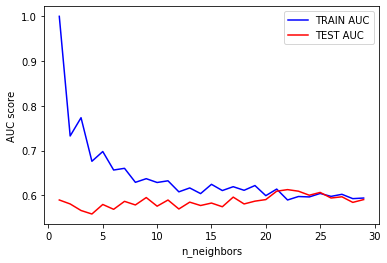

In [46]:
from matplotlib.legend_handler import HandlerLine2D

line1 = plt.plot(neighbors, train_results, 'b', label='TRAIN AUC')
line2 = plt.plot(neighbors, test_results, 'r', label='TEST AUC')

plt.legend(['TRAIN AUC', 'TEST AUC'])

plt.ylabel('AUC score')
plt.xlabel('n_neighbors')
plt.show()

# p in L_p distance
##### This is the power parameter for the Minkowski metric. When p=1, this is equivalent to using manhattan_distance(l1), and euliddean_distance(l2) for p=2. For arbitrary p, minkowski distance (l_p) is used

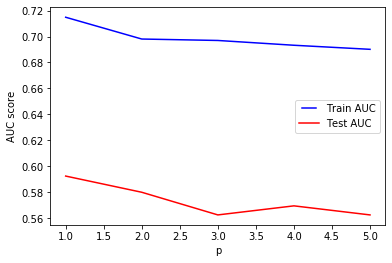

In [52]:
# p in L_p distance 
distances = [1, 2, 3, 4, 5]
train_results = []
test_results = []
for p in distances:
   model = KNeighborsClassifier(p=p)
   model.fit(X_train, y_train)
   train_pred = model.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(distances, train_results, 'b', label='Train AUC')
line2, = plt.plot(distances, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('p')
plt.show()